## Αλγόριθμος βελτιστοποίησης για τη δρομολόγηση απορριμματοφόρων στην πόλη της Καβάλας (Ant Colony Optimization):

Στο μάθημα "Αλγόριθμοι Βελτιστοποίησης-2023" Του ΔΙΠΑΕ Πληροφορικής ζητήθηκε απο την ομάδα μας να επιλυθεί το παρακάτω πρόβλημα:

> Βρείτε το βέλτιστο δρομολόγιο ενός απορριμματοφόρου που διέρχεται από τους κάδους της περιοχής που σας αντιστοιχεί. Σε κάθε ομάδα αντιστοιχεί ένας χάρτης, σε μορφή .kml, με τις θέσεις των κάδων απορριμάτων ανά περιοχή, τον οποίο μπορείτε να κατεβάσετε.

# Διατύπωση προβλήματος βελτιστοποίησης:
Το πρόβλημα αντιμετωπίζεται ως πρόβλημα δρομολόγησης ενός απορριμματοφόρου μεταξύ των κάδων απορριμάτων. Συγκεκριμένα, η εργασία σας είναι να βρείτε τη βέλτιστη διαδρομή που οδηγεί το απορριμματοφόρο από το ένα σημείο (κάδος απορριμάτων) στο άλλο, περνώντας από όλους τους κάδους της περιοχής μας. Στόχος είναι να ελαχιστοποιήσουμε την απόσταση που διανύει το απορριμματοφόρο, προσδιορίζοντας έτσι τη βέλτιστη διαδρομή.

Στους ACO αλγορίθμους, το κάθε μυρμήγκι προσπαθεί να βρει μια βέλτιστη λύση στο πρόβλημα. Για να γίνει αυτό το πρόβλημα μας πρέπει να μετατραπεί σε έναν γράφο με βάρη και να βρεθεί η κοντινότερη διαδρομή πάνω σε αυτό. Σε κάθε επανάληψη το πρώτο βήμα είναι το κάθε μυρμήγκι να βρει μία λύση για το πρόβλημα μας (Μια πιθανή διαδρομή για το πρόβλημα μας). Στο δεύτερο βήμα συγκρίνονται οι λύσεις που βρήκαν τα μυρμήγκια. Στο τρίτο και τελευταίο βήμα είναι να γίνει update η φερμόνη σε κάθε σημείο.

Ψευδοκώδικας :
<img src="optimal_route_files/pseudo_code.png">

Επιλογή επόμενου node :

Για να γίνει επιλογή του επόμενου βήματος το κάθε μυρμήγκι παίρνει σαν παραμέτρους την απόσταση του node και το επίπεδο φερομόνης του επόμενου node.

Σε κάθε επανάληψη το μυρμήγκι δημιουργεί ένα set εφικτών επεκτάσεων(μια λίστα με πιθανότητες) και προχωρά σε ένα επόμενο node ανάλογα με την πιθανότητα του.

Ο μαθηματικός τύπος που χρησιμοποιείτε για την επιλογή του επόμενου βήματος είναι ο εξής
<img src="optimal_route_files/next_move.png">
Οπού :
Txy είναι η ποσότητα της φερομόνης που μεταφέρθηκε
x είναι μια παράμετρος επιρροής για το Txy.
Hxy είναι συνήθως είναι 1/dxy οπού d είναι η απόσταση του επόμενου node

Ανανέωση φερομόνης :

Η φερομόνη γίνεται update στο τέλος όταν κάθε μυρμήγκι βρήκε μια πιθανή λύση οπού τα επίπεδα της φερομόνης αυξάνονται ή μειώνονται ανάλογα εάν ήταν καλές ή κακές λύσεις.

Ένας γενικός κανόνας για την ανανέωση της φερομόνης είναι ο εξής :

<img src="optimal_route_files/phermone.png">

Οπού Txy :

Είναι η ποσότητα φερομόνης που κατατέθηκε από την κατάσταση x-> y
r είναι ένας συντελεστής εξάτμισης.
M είναι ο αριθμός τον μυρμηγκιών
Δktkxy είναι ένα function της μορφής :

<img src="optimal_route_files/phermone2.png">

Οπού Q είναι ένας σταθερός αριθμός και Lk είναι το κόστος της λύσης, δηλαδή η συνολική απόσταση.

# Επεξήγηση επιλογής αλγορίθμου βελτιστοποίησης:
Ο αλγόριθμος που επιλέχθηκε είναι ο Ant Colony Optimization (ACO). Άλλοι αλγόριθμοι όπως ο Γραμμικός Προγραμματισμός, Ακέραιος Προγραμματισμός, Μη Γραμμικός Προγραμματισμός, Στοχαστικές Μέθοδοι, Μεταευριστικές (π.χ. Γενετικοί Αλγόριθμοι) και Δυναμικός Προγραμματισμός μπορεί να έχουν δυνατότητα εφαρμογής, άλλα ο ACO μπορεί να εφαρμοστεί ποιο εύκολα, αφού και ήδη τον είδαμε σε πρόβλημα του πλανόδιου πωλητή που είναι παρόμοιο με το πρόβλημα που πρέπει να λύσουμε τώρα, και σε σχέση με τον αλγόριθμο του πλανόδιου πωλητή, ο ACO είναι πιο αποδοτικός με τον αριθμό των κόμβων που πρέπει να επισκεφτεί ο αλγόριθμος σε αυτό το πρόβλημα.

# Κώδικας:
Αρχικά οι βιβλιοθήκες που θα χρησιμοποιήσουμε...

In [196]:
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import numpy as np
import scipy
import seaborn as sns
from matplotlib import image as mpimg
from tqdm import tqdm
from sklearn.cluster import KMeans

Πρώτα απο το KML αρχείο θα κάνουμε extract τα σημεία και θα τα αποθηκεύσουμε σε ενα dictionary με keys τα ονόματα των σημείων και values τις συντεταγμένες τους. Θα χρησιμοποιήσουμε την xml library για να κάνουμε parse το KML αρχείο. Γραφούμε τη συνάρτηση parse_kml_file που θα κάνει αυτή τη δουλειά.

In [197]:
def parse_kml_file(file_path: str) -> dict:
    placemarks = {}
    try:
        # Parse the KML file
        tree = ET.parse(file_path)
        root = tree.getroot()

        # Find all Placemark elements in the KML
        placemark_elements = root.findall(".//{http://www.opengis.net/kml/2.2}Placemark")

        # Process each Placemark and extract relevant information
        for placemark_element in placemark_elements:
            # Extract the necessary information from the Placemark
            name = placemark_element.find(".//{http://www.opengis.net/kml/2.2}name").text
            coord_string = placemark_element.find(".//{http://www.opengis.net/kml/2.2}coordinates").text

            # Add the placemark to the dictionary with name as the key and [lat, long] list as the value
            placemarks[name] = [float(i) for i in coord_string.split(",")][:2]

    except (ET.ParseError, FileNotFoundError) as e:
        # Handle potential exceptions that may occur during parsing
        print("Error parsing KML file:", e)

    return placemarks

Αποθηκεύουμε τα σημεία σε μια μεταβλητή και σε δύο άλλες μεταβλητές θα αποθηκεύσουμε τα ονόματα των σημείων και τις συντεταγμένες τους.

In [198]:
bins_file_path = "Stena_Panagia___Stena_Profiti_Ilia___Nekrotafeia.kml"
bins_kavala = parse_kml_file(bins_file_path)

bin_names = list(bins_kavala.keys())
bin_points = list(bins_kavala.values())

Στη συνέχεια θα εμφανίσουμε τα σημεία με ένα scatter plot για να δούμε την κατανομή. Θα χρησιμοποιήσουμε τη matplotlib για να κάνουμε το plot.

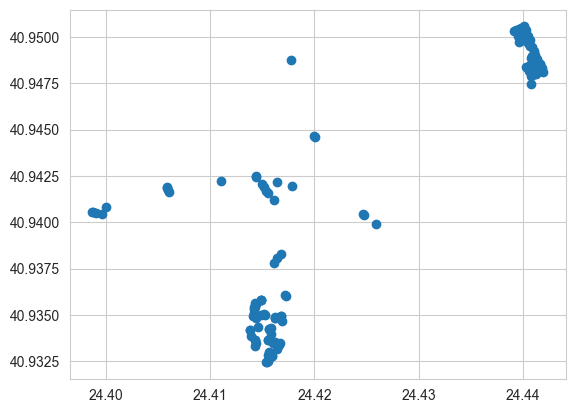

In [199]:
plt.scatter([i[0] for i in bin_points], [i[1] for i in bin_points])

Μπορούμε να ορίσουμε μια συνάρτηση που θα εμφανίζει τα σημεία σε ένα χάρτη. Θα χρησιμοποιήσουμε τη matplotlib.image για να διαβάσουμε την εικόνα του χάρτη.

In [200]:
kavala_map = mpimg.imread("optimal_route_files/kavala_map.png")

Μετά θα φτιάξουμε μια συνάρτηση που θα εμφανίζει τα σημεία στο χάρτη. Θα χρησιμοποιήσουμε τη matplotlib.pyplot για να κάνουμε το plot. Ορίζουμε τη συνάρτηση show_map_points που θα κάνει αυτή τη δουλειά. Είναι απαραίτητο να κάνουμε τις απαραίτητες μετατοπίσεις στον άξονα x και y για να εμφανίζονται σωστά τα σημεία στο χάρτη. Μπορούμε πολύ εύκολα έχοντας δύο γνωστά σημεία στον χάρτη και τις αντίστοιχες συντεταγμένες τους να βρούμε την εξίσωση της ευθείας που τα ενώνει και μετά να βρούμε τις συντεταγμένες του σημείου που θέλουμε να εμφανίσουμε στο χάρτη.

Η σχέσεις που χρησιμοποιήσαμε εμείς είναι η εξής:
Για τα Χ:
<img src="optimal_route_files/metatopisi_x.png">
Για τα Υ:
<img src="optimal_route_files/metatopisi_y.png">


(δεν είναι απόλυτα ακριβής αλλά είναι αρκετά κοντά για να έχουμε μία καλή εικόνα)

Αρα η συνάρτηση θα είναι η εξής:

In [201]:
def show_map_points(path, w=12, h=8):
    plt.figure(figsize=(w,h))
    plt.imshow(kavala_map)
    for i in range(len(path)):
        x_c = 29140.7* path[i][0] - 710754
        y_c = 1.58139 * 10**6 - 38614.2*path[i][1]
        plt.scatter(x_c, y_c, c ='y', marker='*', s=100)
    plt.show()

Μπορούμε τώρα να εμφανίσουμε τα σημεία στο χάρτη.

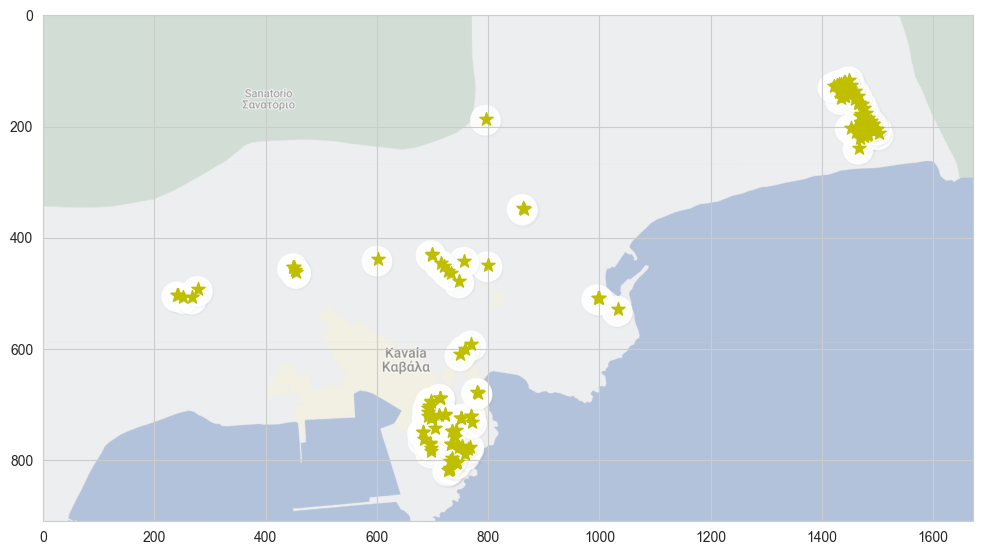

In [202]:
show_map_points(bin_points)

Μία καλή αρχή για την επίλυση του προβλήματος είναι να υπολογίσουμε την απόσταση μεταξύ δύο σημείων. Θα χρησιμοποιήσουμε τη συνάρτηση distance.euclidean της scipy για να υπολογίσουμε την απόσταση μεταξύ δύο σημείων. Ορίζουμε τη συνάρτηση distance που θα κάνει αυτή τη δουλειά.

In [203]:
def distance(p1, p2):
    return scipy.spatial.distance.euclidean(p1, p2)

Παραδείγματα χρήσης της συνάρτησης distance:

In [204]:
print(distance([0,0],[3,4]))

5.0


Το οποίο ισχύει γιατί η απόσταση μεταξύ των σημείων (0,0) και (3,4) είναι 5.
<img src="optimal_route_files/distance_example.png">

Θα χρειαστεί να υπολογίσουμε την απόσταση μεταξύ όλων των σημείων. Θα χρησιμοποιήσουμε τη συνάρτηση distance για να υπολογίσουμε την απόσταση μεταξύ όλων των σημείων. Αυτό θα το κάνουμε με τη χρήση της συνάρτησης distance_matrix της scipy. Ορίζουμε τη συνάρτηση distance_matrix που θα κάνει αυτή τη δουλειά.

In [205]:
def distance_matrix(points):
    dist_array = scipy.spatial.distance_matrix(points, points)
    return dist_array

Παράδειγμα χρήσης της συνάρτησης distance_matrix με τα σημεία των κάδων απορριμμάτων, χρησιμοποιώντας τη βιβλιοθήκη seaborn για να εμφανίσουμε τον πίνακα απόστασης:

<Axes: >

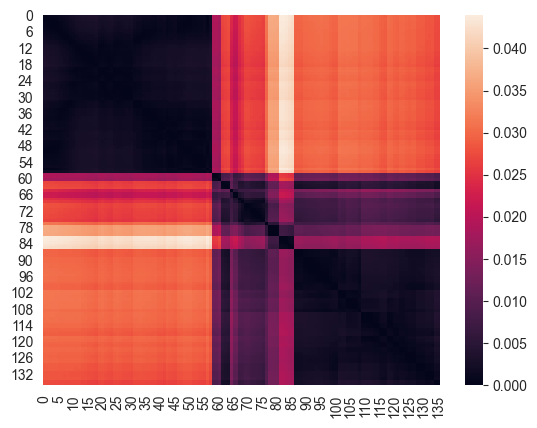

In [206]:
dist_matrix = distance_matrix(bin_points)

sns.heatmap(dist_matrix)

 Στον αλγόριθμο Ant Colony Optimization θα χρειαστούμε των πίνακα αντιστρόφως των αποστάσεων. Ορίζουμε τη συνάρτηση inverse_distance_matrix που θα κάνει αυτή τη δουλειά. Όταν οι αποστάσεις είναι μηδενικές όταν τα σημεία είναι το ίδιο. Στην περίπτωση αυτή γίνεται διαίρεση με το 0. Το διορθώνουμε ορίζοντας τη διαγώνιο σε 1 πριν τη διαίρεση και μετά ξανά σε 0.

In [207]:
def inverse_distance_matrix(points):
    dist_array = distance_matrix(points)

    # Set diagonal elements to a 1 to avoid division by zero
    np.fill_diagonal(dist_array, 1)

    inv_dist_array = 1 / dist_array

    # Set diagonal elements back to 0
    np.fill_diagonal(dist_array, 0)

    return inv_dist_array


Θα ξεκινήσουμε ορίζοντας μία κλάση Ant που θα αναπαριστά τα μυρμήγκια που θα χρησιμοποιήσουμε στον αλγόριθμο Ant Colony Optimization. Η κλάση θα έχει τα εξής χαρακτηριστικά:
- position: η θέση του μυρμηγκιού
- n_locations: ο αριθμός των σημείων του προβλήματος
- places_visited: η λίστα με τα σημεία που έχει επισκεφτεί το μυρμήγκι
- places_left: η λίστα με τα σημεία που έχει να επισκεφτεί το μυρμήγκι
- tour_cost: το κόστος της διαδρομής του μυρμηγκιού
- pheromone_graph: πίνακας με την ποσότητα φερομόνης που αντιστοιχεί σε κάθε πιθανό ζευγάρι σημείων του δικτύου.

Επιπλέον, η Ant περιέχει και τις παρακάτω συναρτήσεις:
- ant_trip: η συνάρτηση που υλοποιεί μία ολοκληρωμένη διαδρομή (σε κάθε επανάληψη του αλγορίθμου)
- get_next_destination: η συνάρτηση που επιλέγει το επόμενο σημείο που θα επισκεφτεί το μυρμήγκι
- update_pheromone_graph: η συνάρτηση που ενημερώνει τον πίνακα φερομόνης μετά από μία διαδρομή
- flush: επαναρχικοποιεί τα δεδομένα του αντικειμένου (ώστε να είναι έτοιμα για την επόμενη επανάληψη)

In [208]:
class Ant:
    def __init__(self, n_locations):
        self.position = None
        self.n_locations = n_locations
        self._initialize()

    def ant_trip(self, g_phero_graph, dist_mat, inv_dist_mat, alpha=1, beta=1, q=1):
        for _ in range(len(self.places_left)):
            # Pick next destination
            next_destination = self.get_next_destination(g_phero_graph, inv_dist_mat, alpha, beta)
            # Add distance into total distance travelled
            self.tour_cost += dist_mat[self.position, next_destination]
            # Change current position and update travel-log variables
            self.position = next_destination
            self.places_visited.append(next_destination)
            self.places_left.remove(next_destination)

        self.update_pheromone_graph(q)

    def get_next_destination(self, g_phero_graph, inv_dist_mat, alpha, beta):
        places_left_indices = list(self.places_left)  # Convert set to a list of indices
        numerator = (g_phero_graph[self.position, places_left_indices] ** alpha) * \
                    (inv_dist_mat[self.position, places_left_indices] ** beta)

        probability = numerator / np.sum(numerator)


        return np.random.choice(places_left_indices, p=probability)

    def update_pheromone_graph(self, q):
        for i, j in zip(self.places_visited[:-1], self.places_visited[1:]):
            self.phero_graph[i, j] = q / self.tour_cost

    def _initialize(self):
        self.position = np.random.choice(self.n_locations)
        self.places_left = set(range(self.n_locations))
        self.places_left.remove(self.position)
        self.places_visited = [self.position]
        self.phero_graph = np.zeros((self.n_locations, self.n_locations))
        self.tour_cost = 0.0

    def flush(self):
        self._initialize()

Ορίζουμε τη συνάρτηση ant_colony_optimization που υλοποιεί τον αλγόριθμο Ant Colony Optimization. Η συνάρτηση θα έχει τα εξής ορίσματα:
- points: οι συντεταγμένες των σημείων του προβλήματος
- n_ants: ο αριθμός των μυρμηγκιών που θα χρησιμοποιηθούν
- n_iterations: ο αριθμός των επαναλήψεων του αλγορίθμου
- alpha: ο παράγοντας που ελέγχει την επιρροή της ποσότητας φερομόνης στην επιλογή του επόμενου σημείου
- beta: ο παράγοντας που ελέγχει την επιρροή της απόστασης στην επιλογή του επόμενου σημείου
- evapo_coef: ο ρυθμός εξάτμισης της φερομόνης

Η συνάρτηση θα επιστρέφει τον πίνακα των συντεταγμένων των σημείων της βέλτιστης διαδρομής, τον πίνακα της βέλτιστης διαδρομής και το κόστος της βέλτιστης διαδρομής.

Αναλυτική επεξήγηση της συνάρτησης:
- Υπολογίζουμε τους πίνακες απόστασης και αντίστροφης απόστασης
- Αρχικοποιούμε τον πίνακα της φερομόνης με την τιμή phero_init
- Αρχικοποιούμε τον πίνακα των μυρμηγκιών ants με τυχαίες θέσεις
- Το Q είναι η σταθερά που χρησιμοποιείται για την ενημέρωση του πίνακα της φερομόνης, ορίζεται ως το αντίστροφο του κόστους της βέλτιστης διαδρομής επειδή θέλουμε να αυξάνεται η φερομόνη όσο μικραίνει το κόστος της διαδρομής


In [209]:
def ant_colony_optimization(points, n_ants, num_iter, alpha=1, beta=1, evapo_coef=0.5):
    # compute (once) the distance matrices
    dist_mat = distance_matrix(points)
    inv_dist_mat = inverse_distance_matrix(points)

    n_locations = len(points)  # total number of points
    ants = [Ant(n_locations) for _ in range(n_ants)]  # ant colony

    # determine initial pheromone value
    phero_init = (inv_dist_mat.mean()) ** (beta / alpha)
    g_phero_graph = np.full((n_locations, n_locations), phero_init)  # pheromone matrix (arbitrary initialization)
    # determine scaling coefficient "Q"
    [ant.ant_trip(g_phero_graph, dist_mat, inv_dist_mat, 1) for ant in ants]
    best_ant = np.argmin([ant.tour_cost for ant in ants])  # ant that scored best in this iteration
    q = ants[best_ant].tour_cost * phero_init / (0.1 * n_ants)

    best_path_length = ants[best_ant].tour_cost
    best_path = ants[best_ant].places_visited.copy()

    monitor_costs = []

    for _ in tqdm(np.arange(num_iter)):

        [ant.ant_trip(g_phero_graph, dist_mat, inv_dist_mat, q) for ant in ants]
        g_phero_graph = update_pheromones(g_phero_graph, ants, evapo_coef).copy()

        iteration_winner = np.argmin([ant.tour_cost for ant in ants])  # ant that scored best in this iteration
        best_path_iteration = ants[iteration_winner].places_visited

        # update global best if better
        if best_path_length > ants[iteration_winner].tour_cost:
            best_path = best_path_iteration.copy()
            best_path_length = ants[iteration_winner].tour_cost

        monitor_costs.append(best_path_length)

        [ant.flush() for ant in ants]

    return best_path, monitor_costs

Όπως είδαμε, οι πιθανότητες για την επιλογή του επόμενου σημείου στη διαδρομή ενός μυρμηγκιού εξαρτώνται και από την ποσότητα φερομόνης που υπάρχει σε κάθε τμήμα του μονοπατιού. Οι ποσότητες αυτές είναι αποθηκευμένες σε έναν πίνακα, ο οποίος θα ανανεώνεται κάθε φορά που ένα μυρμήγκι ολοκληρώνει μια διαδρομή. Η ανανέωση αυτή λαμβάνει υπόψη:

- την αλληλουχία των σημείων που συνθέτουν τη διαδρομή.
- το συνολικό μήκος της διαδρομής (όσο πιο σύντομη, τόσο καλύτερη, επομένως εναποτίθεται περισσότερη φερομόνη, ώστε η διαδρομή να φαίνεται ελκυστική στα υπόλοιπα μυρμήγκια).
- τον συντελεστή εξάτμισης της φερομόνης (λειτουργεί σαν "μνήμη" του συστήματος).

Γράφουμε τώρα τη συνάρτηση ανανέωσης φερομόνης:

In [210]:
def update_pheromones(g_phero_graph,ants,evapo_coef=0.05):

    dim = g_phero_graph.shape[0]

    for i in range(dim):
        for j in range(dim):
            g_phero_graph[i,j] = (1 - evapo_coef)*g_phero_graph[i,j] + np.sum([ant.phero_graph[i,j] for ant in ants])
            g_phero_graph[i,j] = max(g_phero_graph[i,j],1e-08) # avoid division by zero

    return g_phero_graph

Τώρα μπορούμε να τρέξουμε τον αλγόριθμο και να αποθηκεύσουμε την καλύτερη διαδρομή που βρέθηκε σε ένα μεγάλο χρονικό διάστημα:

In [211]:
best_path_order, costs = ant_colony_optimization(
    points=bin_points,
    n_ants=len(bin_points),
    num_iter=200
)

100%|██████████| 20/20 [00:50<00:00,  2.51s/it]


Για να εμφανίσουμε τη διαδρομή, θα χρειαστούμε την αρχική σειρά των σημείων, η οποία είναι αποθηκευμένη στη λίστα `bin_points` και τη σειρά του καλύτερου μονοπατιού, το οποίο είναι αποθηκευμένο στη λίστα `best_path_order`. Ας ορίσουμε μια συνάρτηση που θα εμφανίζει το μονοπάτι και την εξέλιξη του μήκους (cost) του κατά τη διάρκεια του αλγορίθμου:

In [212]:
def plot_map(points: list, best_path: list, monitor_costs: list):
    _, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].plot([p[0] for p in points], [p[1] for p in points], 'o', color='black')
    ax[0].plot([p[0] for p in points], [p[1] for p in points], 'o', color='black')
    ax[0].plot([points[best_path[i]][0] for i in range(len(best_path))],
               [points[best_path[i]][1] for i in range(len(best_path))], color='red', linewidth=2)
    ax[0].set_title('Best path')

    ax[1].plot(monitor_costs)
    ax[1].set_title('Best path length evolution')

    plt.show()

Και τώρα μπορούμε να εμφανίσουμε το αποτέλεσμα:

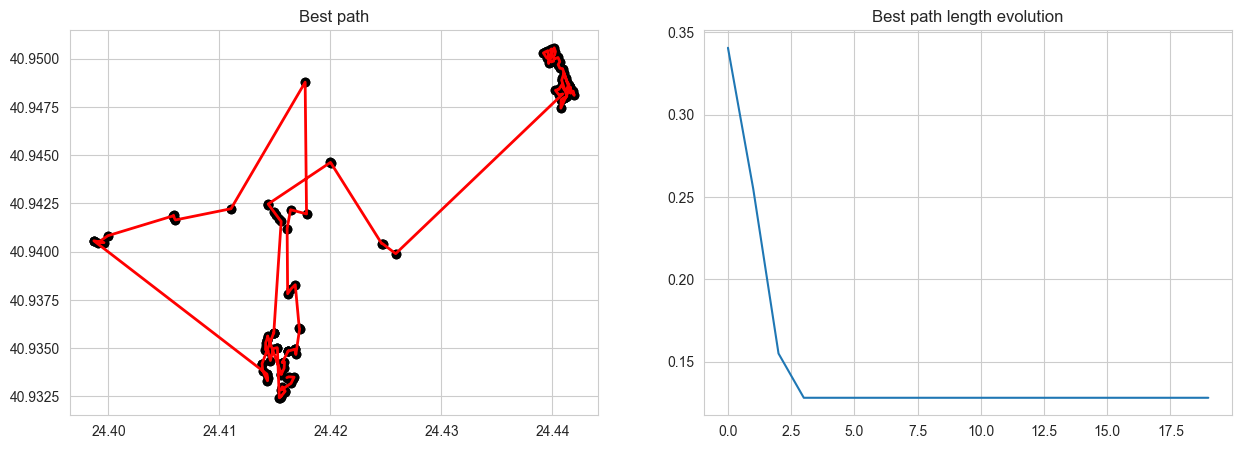

In [213]:
plot_map(bin_points, best_path_order, costs)

Το τελικό κόστος της διαδρομής είναι:

In [214]:
print(costs[-1])

0.1280218538590622


Τέλος, μπορούμε να εμφανίσουμε και το μονοπάτι πάνω στον χάρτη της Καβάλας, θα χρειαστούμε μία καινούργια συνάρτηση, θα χρησιμοποιήσουμε ξανά τις σχέσεις που ορίσαμε προηγουμένως στη συνάρτηση show_map_points() :

In [215]:
def plot_path_on_map(path, order, w=12, h=8):
    plt.figure(figsize=(w, h))
    plt.imshow(kavala_map)

    # Plot the points
    for i in range(len(path)):
        x_c = 29140.7 * path[i][0] - 710754
        y_c = 1.58139 * 10**6 - 38614.2 * path[i][1]

        plt.plot(x_c, y_c, 'y*', markersize=15)

    # Connect the points based on best_path_order
    for i in range(len(order)-1):
        start_idx = order[i]
        end_idx = order[i+1]

        start_point = path[start_idx]
        end_point = path[end_idx]

        start_x_c = 29140.7 * start_point[0] - 710754
        start_y_c = 1.58139 * 10**6 - 38614.2 * start_point[1]

        end_x_c = 29140.7 * end_point[0] - 710754
        end_y_c = 1.58139 * 10**6 - 38614.2 * end_point[1]

        plt.plot([start_x_c, end_x_c], [start_y_c, end_y_c], 'r')

    plt.show()

Τέλος, μπορούμε να εμφανίσουμε το μονοπάτι πάνω στον χάρτη της Καβάλας:

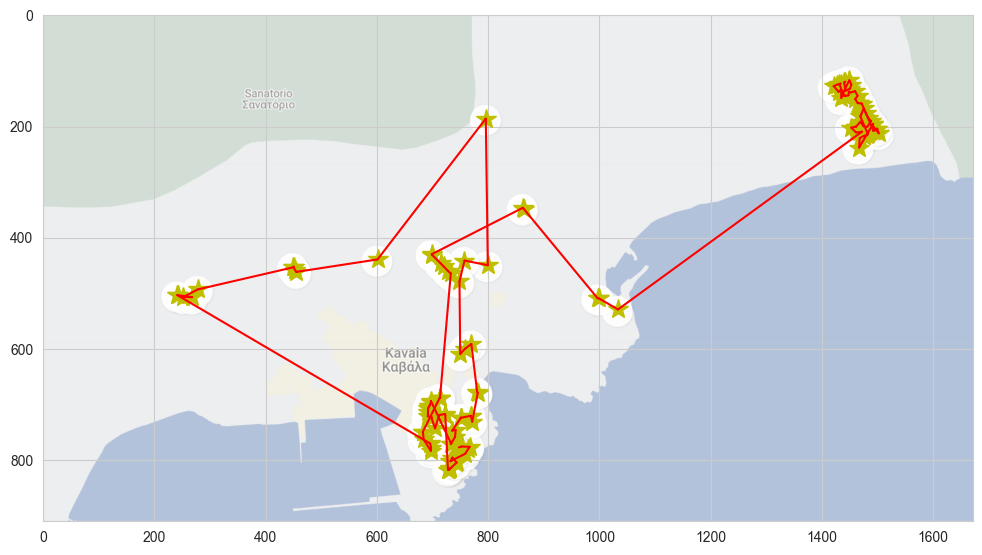

In [216]:
plot_path_on_map(bin_points, best_path_order)

Και για να εμφανίσουμε το μονοπάτι με βάση τα ονόματα των σημείων:

In [217]:
sorted_point_names = np.array(bin_names)[np.argsort(best_path_order)]

print(bin_names[104])
print(sorted_point_names)

1964
['1965' '1966' '1963' '1962' '1949' '1950' '1951' '1952' '1970' '1974'
 '1975' '1991' '1990' '1995' '1994' '1983' '1982' '1984' '1985' '1989'
 '1992' '1993' '1987' '1986' '1977' '1976' '1978' '1979' '1980' '1981'
 '1988' '1973' '1972' '1971' '1953' '1954' '1955' '1944' '1945' '1943'
 '1942' '1941' '1946' '1938' '1939' '1940' '1947' '1948' '1964' '1969'
 '1968' '1956' '1957' '1959' '1958' '1960' '1967' '1961' '1935' '1936'
 '1937' '1900' '1901' '1902' '1906' '1934' '1933' '1905' '1904' '1932'
 '1931' '1930' '1929' '1928' '1927' '1903' '1907' '1910' '1911' '1909'
 '1908' '1916' '1915' '1913' '1914' '1912' '1924' '1926' '1925' '1885'
 '1884' '1883' '1882' '1881' '1880' '1879' '1877' '1878' '1875' '1874'
 '1873' '1921' '1922' '1923' '1920' '1919' '1918' '1917' '1876' '1872'
 '1871' '1869' '1870' '1868' '1867' '1864' '1863' '1862' '1865' '1866'
 '1860' '1861' '1887' '1886' '1888' '1889' '1891' '1890' '1894' '1892'
 '1893' '1896' '1895' '1897' '1899' '1898']


Ας προσθέσουμε στο πρόβλημα έναν περιορισμό να μειώσουμε τις επαναλήψεις για να μήν αργεί τόσο πολύ:

In [234]:
best_path_order, costs = ant_colony_optimization(
    points=bin_points,
    n_ants=len(bin_points),
    num_iter=60
)
print(costs[-1])

 48%|████▊     | 29/60 [01:37<01:43,  3.35s/it]


KeyboardInterrupt: 

Μία βελτιστοποίηση που θα μπορούσαμε να κάνουμε είναι μία ομαδοποίηση και να βρούμε μονοπάτια για κάθε ομάδα ξεχωριστά. Αυτό θα μπορούσε να γίνει με τη χρήση του αλγορίθμου k-means. Ας δούμε πως θα μπορούσαμε να το κάνουμε αυτό:

Αρχικά, θα πρέπει να ομαδοποιήσουμε τα σημεία. Με το μάτι φαίνεται οτι θα ταίριαζαν 3 ομάδες, οπότε θα χρησιμοποιήσουμε τον αλγόριθμο k-means με k=4 (θα ενώσουμε τη 3η και 4η ομάδα σε μία)

Θα χρησιμοποιήσουμε τη Cluster συνάρτηση της βιβλιοθήκης sklearn για να ομαδοποιήσουμε τα σημεία:

In [219]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init='auto').fit(bin_points)

Πρέπει να παραμετροποιήσουμε τη show_map_points() για να μπορούμε να εμφανίσουμε τα σημεία ομαδοποιημένα:

In [220]:
def show_map_points2(points, labels, w=12, h=8):
    plt.figure(figsize=(w, h))
    plt.imshow(kavala_map)

    # Plot the points
    for i in range(len(points)):
        x_c = 29140.7 * points[i][0] - 710754
        y_c = 1.58139 * 10**6 - 38614.2 * points[i][1]

        if labels[i] == 0:
            plt.plot(x_c, y_c, 'r*', markersize=15)
        elif labels[i] == 1:
            plt.plot(x_c, y_c, 'g*', markersize=15)
        elif labels[i] == 2:
            plt.plot(x_c, y_c, 'b*', markersize=15)
        elif labels[i] == 3:
            plt.plot(x_c, y_c, 'y*', markersize=15)

    plt.show()

Ας εμφανίσουμε τα σημεία ομαδοποιημένα χρησιμοποιώντας την καινούρια show_map_points():

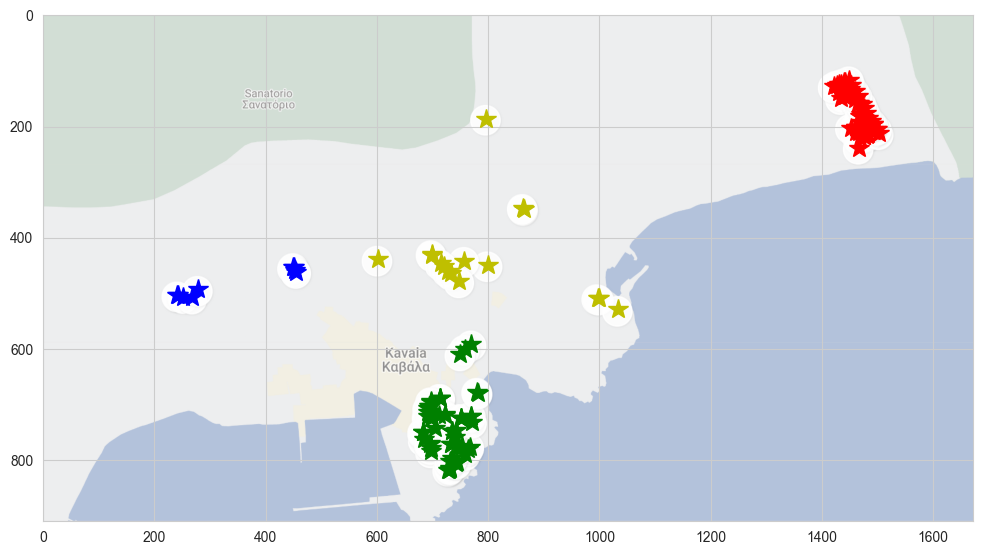

In [221]:
show_map_points2(bin_points, kmeans.labels_)

Θα εφαρμόσουμε την ομαδοποίηση μόνο στην παναγία και στα νεκροταφεία αφού αυτά είναι τα πιο ομαδοποιημένα σημεία και τα άλλα δύο clusters θα τα πάρουμε μαζί:

Θα χρειαστεί να αλλάξουμε λίγο την κλάση Ant και τη συνάρτηση ant_colony_optimization() για να μπορούμε να ορίσουμε starting και ending point έτσι ώστε αντί να αρχικοποιούνται τυχαία, να αρχικοποιούνται τα μισά από την αρχή και τα μισά από το τελευταίο point έτσι θα πετύχουμε να μπορούμε κατά έναν βαθμό να ελέγχουμε το μονοπάτι που θα βρεθεί, έτσι ώστε μετά να τα ενώσουμε:

In [222]:
class Ant2:
    def __init__(self, n_locations, starting_point, ending_point):
        self.starting_point = starting_point
        self.ending_point = ending_point
        self.position = None
        self.n_locations = n_locations
        self._initialize()

    def ant_trip(self, g_phero_graph, dist_mat, inv_dist_mat, alpha=1, beta=1, q=1):
        for _ in range(len(self.places_left)):
            # Pick next destination
            next_destination = self.get_next_destination(g_phero_graph, inv_dist_mat, alpha, beta)
            # Add distance into total distance travelled
            self.tour_cost += dist_mat[self.position, next_destination]
            # Change current position and update travel-log variables
            self.position = next_destination
            self.places_visited.append(next_destination)
            self.places_left.remove(next_destination)

        self.update_pheromone_graph(q)

    def get_next_destination(self, g_phero_graph, inv_dist_mat, alpha, beta):
        places_left_indices = list(self.places_left)  # Convert set to a list of indices
        numerator = (g_phero_graph[self.position, places_left_indices] ** alpha) * \
                    (inv_dist_mat[self.position, places_left_indices] ** beta)

        probability = numerator / np.sum(numerator)


        return np.random.choice(places_left_indices, p=probability)

    def update_pheromone_graph(self, q):
        for i, j in zip(self.places_visited[:-1], self.places_visited[1:]):
            self.phero_graph[i, j] = q / self.tour_cost

    def _initialize(self):
        # Choose randomly between the two edge points
        self.position = np.random.choice([self.starting_point, self.ending_point])
        self.places_left = set(range(self.n_locations))
        self.places_left.remove(self.position)
        self.places_visited = [self.position]
        self.phero_graph = np.zeros((self.n_locations, self.n_locations))
        self.tour_cost = 0.0

    def flush(self):
        self._initialize()

def ant_colony_optimization2(points, n_ants, num_iter, starting_point, ending_point, alpha=1, beta=1, evapo_coef=0.5):
    # compute (once) the distance matrices
    dist_mat = distance_matrix(points)
    inv_dist_mat = inverse_distance_matrix(points)

    n_locations = len(points)  # total number of points
    ants = [Ant2(n_locations, starting_point, ending_point) for _ in range(n_ants)]  # ant colony

    # determine initial pheromone value
    phero_init = (inv_dist_mat.mean()) ** (beta / alpha)
    g_phero_graph = np.full((n_locations, n_locations), phero_init)  # pheromone matrix (arbitrary initialization)
    # determine scaling coefficient "Q"
    [ant.ant_trip(g_phero_graph, dist_mat, inv_dist_mat, 1) for ant in ants]
    best_ant = np.argmin([ant.tour_cost for ant in ants])  # ant that scored best in this iteration
    q = ants[best_ant].tour_cost * phero_init / (0.1 * n_ants)

    best_path_length = ants[best_ant].tour_cost
    best_path = ants[best_ant].places_visited.copy()

    monitor_costs = []

    for _ in tqdm(np.arange(num_iter)):

        [ant.ant_trip(g_phero_graph, dist_mat, inv_dist_mat, q) for ant in ants]
        g_phero_graph = update_pheromones(g_phero_graph, ants, evapo_coef).copy()

        iteration_winner = np.argmin([ant.tour_cost for ant in ants])  # ant that scored best in this iteration
        best_path_iteration = ants[iteration_winner].places_visited

        # update global best if better
        if best_path_length > ants[iteration_winner].tour_cost:
            best_path = best_path_iteration.copy()
            best_path_length = ants[iteration_winner].tour_cost

        monitor_costs.append(best_path_length)

        [ant.flush() for ant in ants]

    return best_path, monitor_costs

Τώρα θα επιλέξουμε τα σημεία που θα ήταν ιδανικά με το μάτι για να είναι τα starting και ending points για κάθε cluster.
Για το μονοπάτι τις Παναγίας θα επιλέξω τον κάδο 1963(αριστερά) και τον κάδο 1921(δεξιά).
Για το μονοπάτι νεκροταφεία θα επιλέξω τον κάδο 1917(κάτω) και τον κάδο 1878(πάνω).
Για το μονοπάτι της υπόλοιπης Καβάλας θα επιλέξω τον κάδο 1941(αριστερά) και τον κάδο 1935(δεξιά).

Τώρα που έχουμε τα σημεία ομαδοποιημένα, μπορούμε να βρούμε τα μονοπάτια για κάθε ομάδα ξεχωριστά. Αρχικά θα τα χωρίσουμε σε ξεχωριστά arrays.

In [223]:
nekrotafia_cluster = []
panagia_cluster = []
nekrotafia_cluster_names = []
panagia_cluster_names = []
rest_of_kavala =[]
rest_of_kavala_names =[]

for i in range(len(bin_points)):
    if kmeans.labels_[i] == 0:
        nekrotafia_cluster.append(bin_points[i])
        nekrotafia_cluster_names.append(bin_names[i])
    elif kmeans.labels_[i] == 1:
        panagia_cluster.append(bin_points[i])
        panagia_cluster_names.append(bin_names[i])
    else:
        rest_of_kavala.append(bin_points[i])
        rest_of_kavala_names.append(bin_names[i])


Τώρα ας συγκρίνουμε τα αποτελέσματα με Clustering και χωρίς Clustering.

In [ ]:
best_path_order, costs = ant_colony_optimization(
    points=bin_points,
    n_ants=len(bin_points),
    num_iter=60
)
plot_path_on_map(bin_points, best_path_order)
plot_map(bin_points, best_path_order, costs)
print("Το κόστος του μονοπατιού χωρίς clustering είναι: ", costs[-1])


Ας βρούμε τα μονοπάτια για κάθε ομάδα ξεχωριστά χρησιμοποιώντας τον ACO και ορίζοντας τα επιθήματα starting και ending points.:

In [236]:
nekrotafia_best_path_order, nekrotafia_costs = ant_colony_optimization2(
    points=nekrotafia_cluster,
    n_ants=len(nekrotafia_cluster),
    num_iter=60,
    starting_point=nekrotafia_cluster_names.index("1878"),
    ending_point=nekrotafia_cluster_names.index("1917")
)


panagia_best_path_order, panagia_costs = ant_colony_optimization2(
    points=panagia_cluster,
    n_ants=len(panagia_cluster),
    num_iter=80,
    starting_point=panagia_cluster_names.index("1963"),
    ending_point=panagia_cluster_names.index("1921")
)


rest_of_kavala_best_path_order, rest_of_kavala_costs = ant_colony_optimization2(
    points=rest_of_kavala,
    n_ants=len(rest_of_kavala),
    num_iter=40,
    starting_point=rest_of_kavala_names.index("1941"),
    ending_point=rest_of_kavala_names.index("1935")
)

100%|██████████| 60/60 [00:03<00:00, 18.54it/s]


Τώρα θα ενώσουμε τα μονοπάτια σε ενα ενιαίο μονοπάτι.

In [237]:
combined_path = []
combined_points = []


combined_path.extend(rest_of_kavala_best_path_order)
combined_path.extend((np.array(panagia_best_path_order) + len(rest_of_kavala)).tolist())
combined_path.extend((np.array(nekrotafia_best_path_order) + len(rest_of_kavala) + len(panagia_cluster)).tolist())

combined_points.extend(rest_of_kavala)
combined_points.extend(panagia_cluster)
combined_points.extend(nekrotafia_cluster)

Δέν πρέπει να ξεχάσουμε να προσθέσουμε και το κόστος των συνδέσμων μεταξύ των ομάδων!

In [238]:
combined_costs = rest_of_kavala_costs[-1] + panagia_costs[-1] + nekrotafia_costs[-1]
link_a1_point = rest_of_kavala[rest_of_kavala_best_path_order[-1]]
link_a2_point = panagia_cluster[panagia_best_path_order[0]]
link_b1_point = panagia_cluster[panagia_best_path_order[-1]]
link_b2_point = nekrotafia_cluster[nekrotafia_best_path_order[0]]

combined_costs += distance(link_a1_point, link_a2_point)
combined_costs += distance(link_b1_point, link_b2_point)

Τώρα να δούμε με Clustering...

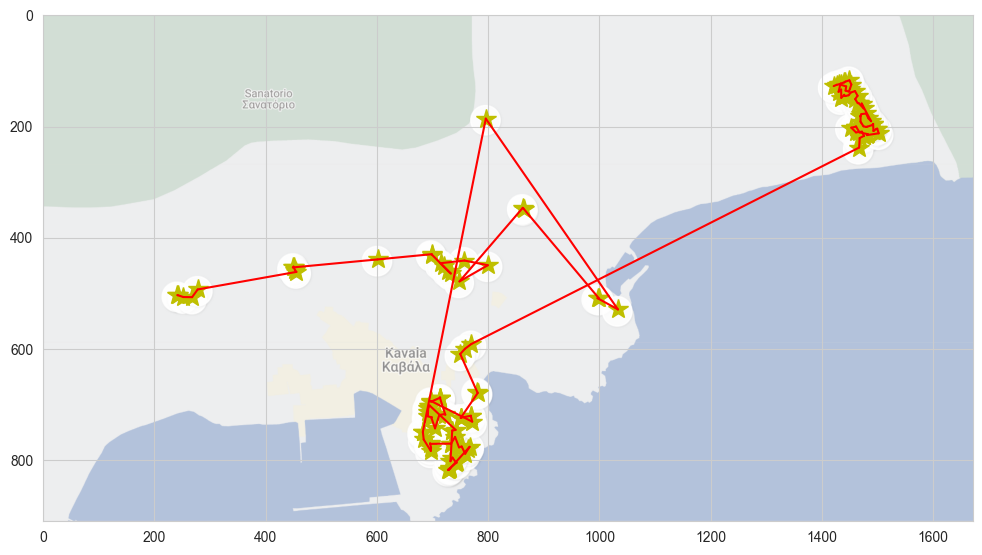

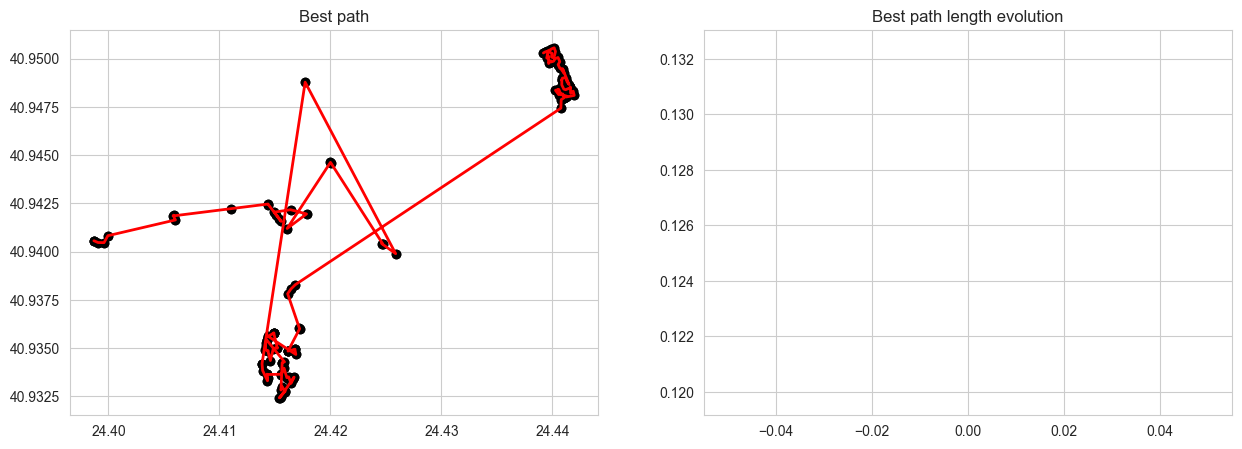

Το κόστος του μονοπατιού με clustering είναι:  0.12609648165964468


In [239]:
plot_path_on_map(combined_points, combined_path)
print("Το κόστος του μονοπατιού με clustering είναι: ", combined_costs)